# Prerequisites


In [13]:
# pip install GTSAM to use the pose in SE(3)
!pip install gtsam

In [0]:
# pylint: disable=invalid-name, E1101

from __future__ import print_function

import math
import unittest
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # pylint: disable=W0611

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Required to do animations in colab
from matplotlib import animation
from IPython.display import HTML

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
from gtsam import Pose3
from gtsam import Rot3
from gtsam import Point3

In [0]:
# Set plot parameters
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rc('animation', html='jshtml') # needed for animations!
arrowOptions = dict(head_width=.02,head_length=.02, width=0.01)

# Utility Funcions
You can use the following functions to compute the different vector operations that you might need during the assignemnt.

In [0]:
# Some utility functions for Pose3
def vector(w, x, y, z):
    """Create 3D double numpy array."""
    return np.array([w, x, y, z], dtype=np.float)


def compose(*poses):
    """Compose all Pose3 transforms given as arguments from left to right."""
    return reduce((lambda x, y: x.compose(y)), poses)


def delta(g0, g1):
    """Difference between two SE(3) poses."""
    xy_diff = np.sqrt(g1.x()**2 + g1.y()**2) - np.sqrt(g0.x()**2 + g0.y()**2)
    z_diff = g1.z() - g0.z() 
    return np.array([xy_diff, z_diff], dtype=np.float)


def disc_trajectory(pos_init, velocity_init, time_scope=0.5, N=50):
    x_disc = np.zeros(N)
    y_disc = np.zeros(N)
    z_disc = np.zeros(N)
    for i in range(N):
      time_step = i * time_scope / N
      x_disc[i] = pos_init[0] + velocity_init[0] * time_step 
      y_disc[i] = pos_init[1] + velocity_init[1] * time_step 
      z_disc[i] = pos_init[2] + velocity_init[2] * time_step - 0.5 * 980 * time_step ** 2
    return x_disc, y_disc, z_disc

# Helper Funcions

In [0]:
def expmap(Rotate, Transform):
  mat1 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), Transform)
  mat2 = Pose3(Rotate, gtsam.Point3(0, 0, 0))
  min_point = gtsam.Point3(-Transform.x(), -Transform.y(), -Transform.z())
  mat3 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), min_point)
  exponent_Result = compose(mat1, mat2, mat3)
  return exponent_Result

# Manipulator Class
We will work with a three link arm with three revolute joints (RRR). This class has its initialization function that should be left as it is and you will have to work if the other functions to have a working system.

The functions that you will have to implement are:


*   fk: Forward Kinematics
*   con: Solving Forward Kinematics using conjugation form
*   poe: Solving Forward Kinematics using power of exponentials form
*   Jacobian: Computes the manipulator Jacobian in SE(3)
*   ik: Computes Inverse Kinematics



In [0]:
# The Pincher manipulator class

class Pincher(object):
    """Pincher class."""

    def __init__(self):
        self.L1 = 12.0
        self.L2 = 31.5
        self.L3 = 31.5
        self.L4 = 19.5
        self.radius = 10.0
        self.gripper = 12.0

    def fk(self, q):
        """ Forward kinematics.
            Takes numpy array of joint angles, in radians.
        """
        XS_1 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, 0))
        Z1_1 = Pose3(gtsam.Rot3.Ypr(q[0], 0, 0), gtsam.Point3(0, 0, 0))
        X1_2 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L1))
        Z2_2 = Pose3(gtsam.Rot3.Ypr(0, 0, q[1]), gtsam.Point3(0, 0, 0))
        X2_3 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L2))
        Z3_3 = Pose3(gtsam.Rot3.Ypr(0, 0, q[2]), gtsam.Point3(0, 0, 0))
        X3_4 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L3))
        Z4_4 = Pose3(gtsam.Rot3.Ypr(0, 0, q[3]), gtsam.Point3(0, 0, 0))
        X4_t = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L4))
        Forward_Link = compose(XS_1, Z1_1, X1_2, Z2_2, X2_3, Z3_3, X3_4, Z4_4, X4_t)
        return Forward_Link

    def con(self, q):
        """ Forward kinematics, conjugation form.
            Takes numpy array of joint angles, in radians.
        """
        XS_1 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, 0))
        X1_2 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L1))
        X2_3 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L2))
        X3_4 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L3))
        X4_t = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, self.L4))
        Ts_t0 = compose(XS_1, X1_2, X2_3, X3_4, X4_t)
        exp1 = expmap(gtsam.Rot3.Ypr(q[0], 0, 0), gtsam.Point3(0, 0, 0))
        exp2 = expmap(gtsam.Rot3.Ypr(0, 0, q[1]), gtsam.Point3(0, 0, self.L1))
        exp3 = expmap(gtsam.Rot3.Ypr(0, 0, q[2]), gtsam.Point3(0, 0, self.L1 + self.L2))
        exp4 = expmap(gtsam.Rot3.Ypr(0, 0, q[3]), gtsam.Point3(0, 0, self.L1 + self.L2 + self.L3))
        Ts_t = compose(exp1, exp2, exp3, exp4, Ts_t0)
        return Ts_t
    
    def jacobian(self, q):
        """ Calculate manipulator Jacobian.
            Takes numpy array of joint angles, in radians.
        """        
        alpha = q[1] + q[2]
        
        Jacobian_Joint2_C = self.L2 * math.cos(q[1]) + self.L3 * math.cos(alpha)
        Jacobian_Joint3_C = self.L3 * math.cos(alpha)

        Jacobian_Joint2_S = self.L2 * math.sin(q[1]) + self.L3 * math.sin(alpha)
        Jacobian_Joint3_S = self.L3 * math.sin(alpha)

        Jacobian = np.array([[-Jacobian_Joint2_C, -Jacobian_Joint3_C],
               [-Jacobian_Joint2_S, -Jacobian_Joint3_S]])

        return Jacobian

    def terminal_determine(self, disc_pos):
        sin1 = disc_pos[1]/np.sqrt(disc_pos[0] ** 2 + disc_pos[1] ** 2)
        cos1 = disc_pos[0]/np.sqrt(disc_pos[0] ** 2 + disc_pos[1] ** 2)

        x_comp = disc_pos[0] - (self.radius + self.L4 + self.gripper) * cos1
        y_comp = disc_pos[1] - (self.radius + self.L4 + self.gripper) * sin1

        if ((x_comp ** 2 + y_comp ** 2 + (disc_pos[2] - self.L1) ** 2) > (self.L2 + self.L3) ** 2):
          if disc_pos[2] > 70:
            distance = np.sqrt(x_comp ** 2 + y_comp ** 2 + (disc_pos[2] - self.L1) ** 2)
            x_config = (self.L2 + self.L3)/distance * (disc_pos[0] - (self.radius + self.L4 + self.gripper) * cos1) + self.L4 * cos1
            y_config = (self.L2 + self.L3)/distance * (disc_pos[1] - (self.radius + self.L4 + self.gripper) * sin1) + self.L4 * sin1
            z_config = (self.L2 + self.L3)/distance * (disc_pos[2] - self.L1) + self.L1
          else:
            x_config = (np.sqrt((self.L2 + self.L3) ** 2 - (disc_pos[2] - self.L1) ** 2) + self.L4) * cos1
            y_config = (np.sqrt((self.L2 + self.L3) ** 2 - (disc_pos[2] - self.L1) ** 2) + self.L4) * sin1
            z_config = disc_pos[2]
          track_flag = 0
        else:
          x_config = disc_pos[0] - (self.radius + self.gripper) * cos1
          y_config = disc_pos[1] - (self.radius + self.gripper) * sin1
          z_config = disc_pos[2]
          track_flag = 1
        
        terminal_mat = np.array([[cos1, 0, sin1, x_config], [-sin1, 0, cos1, y_config], [0, 1, 0, z_config], [0, 0, 0, 1]])
        return terminal_mat
    
    def pose3packer(self, terminal_mat):
        return Pose3(gtsam.Rot3.Ypr(np.arcsin(terminal_mat[0, 2]), 0, math.radians(-90)), gtsam.Point3(-terminal_mat[1, 3], terminal_mat[0, 3], terminal_mat[2, 3]))


    def ik(self, q_init, sTt_desired, e=0.001):
        """ Inverse kinematics.
            Takes desired Pose2 of tool T with respect to base S.
            Optional: e: error norm threshold
        """
        q_iter = q_init  # take initial estimate well within workspace
        lamb = 100
        I = np.eye(2) * lamb
        change_flag = 0
        error = 0
        while np.linalg.norm(delta(self.fk(q_iter), sTt_desired)) > e:
          diff = np.dot(np.linalg.inv(np.matmul(self.jacobian(q_iter).T, self.jacobian(q_iter)) + I), np.matmul(self.jacobian(q_iter).T, delta(self.fk(q_iter), sTt_desired)))
          q_iter[0] = sTt_desired.rotation().yaw()
          q_iter[1] += diff[0]
          q_iter[2] += diff[1]
          q_iter[3] = -math.pi/2 - q_iter[2] - q_iter[1]
          
          if (np.linalg.norm(delta(self.fk(q_iter), sTt_desired)) >= error) and (change_flag == 0):
            lamb -= 2
          else:
            lamb += 2
            change_flag = 1

          error = np.linalg.norm(delta(self.fk(q_iter), sTt_desired))
          
        # return result in interval [-pi,pi)
        return np.remainder(q_iter+math.pi, 2*math.pi)-math.pi



# Scenario 1



In [19]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(1)
ax = fig.gca(projection='3d')
plt.close()
N=50
size=100
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
ax.set_zlim((0, 120))
omega = 2*math.pi/N

arm = Pincher()

q = np.radians(np.array([-45, -30, -30, -30], dtype = float))

# Plot the trajectory of the flying disc 
pos_init = [50, -100, 120]
velocity_init = [0, 400, 0]
x_disc, y_disc, z_disc = disc_trajectory(pos_init, velocity_init, time_scope=0.5, N=N)

lock_flag = 0
distance_count = 0

x_ter = []
y_ter = []
z_ter = []

q_1 = []
q_2 = []
q_3 = []
q_4 = []

distance_list = []

# animation function. This is called sequentially  
def animate(i):
  global pose
  global arm
  global q
  global lock_flag
  global x_ter
  global y_ter
  global z_ter
  global distance_list
  global q_1
  global q_2
  global q_3
  global q_4

  ter_pose = arm.terminal_determine([x_disc[i], y_disc[i], z_disc[i]])
  sTt_pose = arm.pose3packer(ter_pose)
  q = arm.ik(q, sTt_pose)

  # ------------------------- ANIMATION ----------------------------------------------------
  XS_1 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, 0))
  Z1_1 = Pose3(gtsam.Rot3.Ypr(q[0], 0, 0), gtsam.Point3(0, 0, 0))
  X1_2 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L1))
  sTl1 = compose(XS_1, Z1_1, X1_2)
  t1 = sTl1.translation()
  
  ax.clear()
  ax.plot(x_disc, y_disc, z_disc, linewidth=3, color='r')
  ax.plot(x_ter, y_ter, z_ter, linewidth=3, color='b')

  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  ax.set_zlim((0, 120))
  ax.plot([0, t1.y()], [0, -t1.x()], [0, t1.z()], linewidth=3, color='k')
  
  Z2_2 = Pose3(gtsam.Rot3.Ypr(0, 0, q[1]), gtsam.Point3(0, 0, 0))
  X2_3 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L2))
  sTl2 = compose(sTl1, Z2_2, X2_3)
  t2 = sTl2.translation()
  ax.plot([t1.y(), t2.y()], [-t1.x(), -t2.x()], [t1.z(), t2.z()], linewidth=3, color='r')

  Z3_3 = Pose3(gtsam.Rot3.Ypr(0, 0, q[2]), gtsam.Point3(0, 0, 0))
  X3_4 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L3))
  sTl3 = compose(sTl2, Z3_3, X3_4)
  t3 = sTl3.translation()
  ax.plot([t2.y(), t3.y()], [-t2.x(), -t3.x()], [t2.z(), t3.z()], linewidth=3, color='g')


  Z4_4 = Pose3(gtsam.Rot3.Ypr(0, 0, q[3]), gtsam.Point3(0, 0, 0))
  X4_t = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L4))
  sTl4 = compose(sTl3, Z4_4, X4_t)
  t4 = sTl4.translation()
  ax.plot([t3.y(), t4.y()], [-t3.x(), -t4.x()], [t3.z(), t4.z()], linewidth=3, color='b')

  x_ter.append(t4.y())
  y_ter.append(-t4.x())
  z_ter.append(t4.z())

  q_1.append(q[0])
  q_2.append(q[1])
  q_3.append(q[2])
  q_4.append(q[3])

  distance = np.sqrt((t4.y()-x_disc[i])**2+(-t4.x()-y_disc[i])**2+(t4.z()-z_disc[i])**2)
  distance_list.append(distance)

  if (distance<=(12.0 + 10.0))and(lock_flag == 0):
    arm.gripper -= 2
  if (arm.gripper == 2)and(lock_flag == 0):
    print('Caught the flying disc in the iteration', i)
    lock_flag = 1

animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=False)

Caught the flying disc in the iteration 35


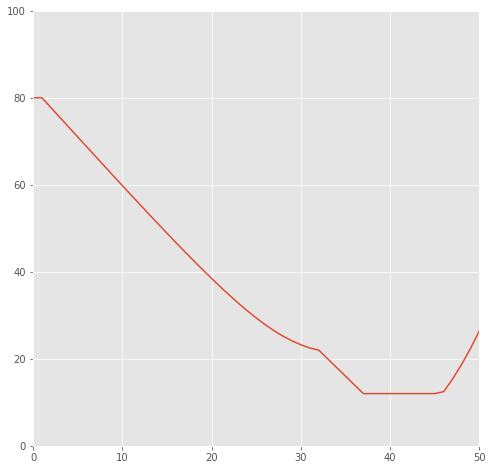

In [20]:
fig = plt.figure(1)
ax = fig.gca()
ax.set_xlim((0, 50))
ax.set_ylim((0, 100))
ax.plot(distance_list)

# Scenario 2



In [26]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(1)
ax = fig.gca(projection='3d')
plt.close()
N=50
size=100
ax.set_xlim((-size, size))
ax.set_ylim((-size, size))
ax.set_zlim((0, 120))
omega = 2*math.pi/N

arm = Pincher()
q = np.radians(np.array([-45, -30, -30, -30], dtype = float))

# Plot the trajectory of the flying disc 
pos_init = [100, -100, 105]
velocity_init = [-200, 400, 100]
x_disc, y_disc, z_disc = disc_trajectory(pos_init, velocity_init, time_scope=0.5, N=N)

lock_flag = 0
distance_count = 0

x_ter = []
y_ter = []
z_ter = []

q_1 = []
q_2 = []
q_3 = []
q_4 = []

distance_list = []

# animation function. This is called sequentially  
def animate(i):
  global pose
  global arm
  global q
  global lock_flag
  global x_ter
  global y_ter
  global z_ter
  global distance_list
  global q_1
  global q_2
  global q_3
  global q_4

  ter_pose = arm.terminal_determine([x_disc[i], y_disc[i], z_disc[i]])
  sTt_pose = arm.pose3packer(ter_pose)
  q = arm.ik(q, sTt_pose)

  # ------------------------- ANIMATION ----------------------------------------------------
  XS_1 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, 0))
  Z1_1 = Pose3(gtsam.Rot3.Ypr(q[0], 0, 0), gtsam.Point3(0, 0, 0))
  X1_2 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L1))
  sTl1 = compose(XS_1, Z1_1, X1_2)
  t1 = sTl1.translation()
  
  ax.clear()
  ax.plot(x_disc, y_disc, z_disc, linewidth=3, color='r')
  ax.plot(x_ter, y_ter, z_ter, linewidth=3, color='b')

  ax.set_xlim((-size, size))
  ax.set_ylim((-size, size))
  ax.set_zlim((0, 120))
  ax.plot([0, t1.y()], [0, -t1.x()], [0, t1.z()], linewidth=3, color='k')
  
  Z2_2 = Pose3(gtsam.Rot3.Ypr(0, 0, q[1]), gtsam.Point3(0, 0, 0))
  X2_3 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L2))
  sTl2 = compose(sTl1, Z2_2, X2_3)
  t2 = sTl2.translation()
  ax.plot([t1.y(), t2.y()], [-t1.x(), -t2.x()], [t1.z(), t2.z()], linewidth=3, color='r')

  Z3_3 = Pose3(gtsam.Rot3.Ypr(0, 0, q[2]), gtsam.Point3(0, 0, 0))
  X3_4 = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L3))
  sTl3 = compose(sTl2, Z3_3, X3_4)
  t3 = sTl3.translation()
  ax.plot([t2.y(), t3.y()], [-t2.x(), -t3.x()], [t2.z(), t3.z()], linewidth=3, color='g')


  Z4_4 = Pose3(gtsam.Rot3.Ypr(0, 0, q[3]), gtsam.Point3(0, 0, 0))
  X4_t = Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0, arm.L4))
  sTl4 = compose(sTl3, Z4_4, X4_t)
  t4 = sTl4.translation()
  ax.plot([t3.y(), t4.y()], [-t3.x(), -t4.x()], [t3.z(), t4.z()], linewidth=3, color='b')
  
  x_ter.append(t4.y())
  y_ter.append(-t4.x())
  z_ter.append(t4.z())

  q_1.append(q[0])
  q_2.append(q[1])
  q_3.append(q[2])
  q_4.append(q[3])


  distance = np.sqrt((t4.y()-x_disc[i])**2+(-t4.x()-y_disc[i])**2+(t4.z()-z_disc[i])**2)
  distance_list.append(distance)

  if (distance<=(12.0 + 10.0))and(lock_flag == 0):
    arm.gripper -= 2
  if (arm.gripper == 2)and(lock_flag == 0):
    print('Caught the flying disc in the iteration', i)
    lock_flag = 1

animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=False)

Caught the flying disc in the iteration 42


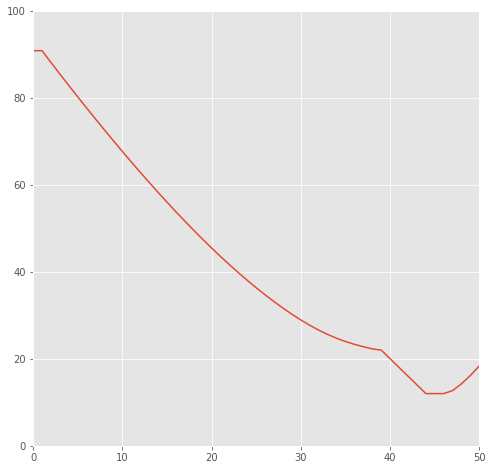

In [27]:
fig = plt.figure(1)
ax = fig.gca()
ax.set_xlim((0, 50))
ax.set_ylim((0, 100))
ax.plot(distance_list)